【問題1】スクラッチを振り返る<br>

【回答】<br>
・重み、バイアスの初期化、更新<br>
・エポックのループ<br>
・活性化関数を通して出力する。<br>
・forward,back propagationを繰り返す。<br>

【問題2】スクラッチとTensorFlowの対応を考える

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
# tensorflow1系
# import tensorflow as tf
# tensorflow2系
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [2]:
# 読み込み
iris_dataset = load_iris()

# 整形
iris_dataframe = pd.DataFrame(data=iris_dataset.data, columns=iris_dataset.feature_names)
iris_datalabel = pd.DataFrame(data=iris_dataset.target,columns=['Species'])
df = pd.concat([iris_dataframe,iris_datalabel],axis=1)

#%% md

# ミニバッチクラス

#%%

class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [3]:
#%% md

# 問題2　スクラッチとTensorFlowの対応を考える

#%% md

## データ準備

#%%

# 2値分類のため絞り込み
df2 = df[(df["Species"] == 0)|(df["Species"] == 1)]

# 説明変数と目的変数に分割
y = df2["Species"]
X = df2.loc[:, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

# 訓練データ/テストデータ/評価データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 正規化
X_train /= 255
X_test /= 255
X_val /= 255

#%% md

## tensorflowで学習

#%%

# 各種変数定義
learning_rate = 0.01
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

Epoch 0, train_loss : 1.1074, val_loss : 0.8296, train_acc : 0.469, val_acc : 0.625
Epoch 1, train_loss : 1.9878, val_loss : 2.6489, train_acc : 0.531, val_acc : 0.375
Epoch 2, train_loss : 1.3016, val_loss : 1.7220, train_acc : 0.531, val_acc : 0.375
Epoch 3, train_loss : 2.0142, val_loss : 1.4353, train_acc : 0.469, val_acc : 0.625
Epoch 4, train_loss : 0.6286, val_loss : 0.5327, train_acc : 0.469, val_acc : 0.625
Epoch 5, train_loss : 0.5285, val_loss : 0.5057, train_acc : 0.953, val_acc : 0.938
Epoch 6, train_loss : 0.5867, val_loss : 0.4912, train_acc : 0.469, val_acc : 0.625
Epoch 7, train_loss : 0.9390, val_loss : 0.6863, train_acc : 0.469, val_acc : 0.625
Epoch 8, train_loss : 0.9537, val_loss : 0.6915, train_acc : 0.469, val_acc : 0.625
Epoch 9, train_loss : 0.7140, val_loss : 0.5334, train_acc : 0.469, val_acc : 0.625
Epoch 10, train_loss : 0.6323, val_loss : 0.4785, train_acc : 0.469, val_acc : 0.625
Epoch 11, train_loss : 0.6522, val_loss : 0.4846, train_acc : 0.469, val_ac

In [4]:
#%% md

# 問題3　3種類すべての目的変数を使用したIrisのモデルを作成

#%% md

## データ準備

#%%

# 説明変数と目的変数に分割
y = df["Species"]
X = df.loc[:, ["sepal length (cm)", "sepal width (cm)", "petal length (cm)", "petal width (cm)"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]

# 訓練データ/テストデータ/評価データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
y_val_one_hot = enc.transform(y_val)
y_test_one_hot = enc.transform(y_test)

# 正規化
X_train /= 255
X_test /= 255
X_val /= 255

#%% md

## tensorflowで学習

#%%

# 各種変数定義
learning_rate = 0.01
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 3 # 2値分類からの変更箇所

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train_one_hot, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)) # 2値分類からの変更箇所
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1)) # 2値分類からの変更箇所
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train_one_hot})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val_one_hot})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

Epoch 0, train_loss : 4.5107, val_loss : 4.6722, train_acc : 0.312, val_acc : 0.292
Epoch 1, train_loss : 2.0330, val_loss : 2.0369, train_acc : 0.365, val_acc : 0.375
Epoch 2, train_loss : 3.2035, val_loss : 3.1690, train_acc : 0.323, val_acc : 0.333
Epoch 3, train_loss : 2.5130, val_loss : 2.4887, train_acc : 0.323, val_acc : 0.333
Epoch 4, train_loss : 1.5210, val_loss : 1.5295, train_acc : 0.323, val_acc : 0.333
Epoch 5, train_loss : 1.3187, val_loss : 1.3660, train_acc : 0.312, val_acc : 0.292
Epoch 6, train_loss : 1.3918, val_loss : 1.4506, train_acc : 0.312, val_acc : 0.292
Epoch 7, train_loss : 1.3348, val_loss : 1.3924, train_acc : 0.312, val_acc : 0.292
Epoch 8, train_loss : 1.2263, val_loss : 1.2798, train_acc : 0.312, val_acc : 0.292
Epoch 9, train_loss : 1.2437, val_loss : 1.2979, train_acc : 0.312, val_acc : 0.292
Epoch 10, train_loss : 1.1768, val_loss : 1.2283, train_acc : 0.312, val_acc : 0.292
Epoch 11, train_loss : 0.9736, val_loss : 1.0143, train_acc : 0.604, val_ac

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review 

Epoch 0, loss : 17480896.0000, val_loss : 15796340.0000
Epoch 1, loss : 3409438.0000, val_loss : 2381235.5000
Epoch 2, loss : 1949718.7500, val_loss : 1279496.8750
Epoch 3, loss : 1211029.1250, val_loss : 769370.8750
Epoch 4, loss : 792286.1875, val_loss : 463125.5938
Epoch 5, loss : 519826.9062, val_loss : 260110.6562
Epoch 6, loss : 348251.9375, val_loss : 149723.4375
Epoch 7, loss : 253131.0312, val_loss : 100077.8203
Epoch 8, loss : 190137.8125, val_loss : 76798.9375
Epoch 9, loss : 143641.3750, val_loss : 60984.2070


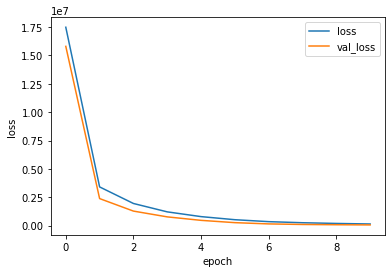

test_mse : 368400.219


In [5]:
#%% md

# 問題4　House Pricesのモデルを作成

#%% md

## データ準備

#%%

dataset_path ="train.csv"
df = pd.read_csv(dataset_path)

y = df["SalePrice"]
X = df.loc[:, ["GrLivArea", "YearBuilt"]]
y = np.array(y)
X = np.array(X)
y = y.astype(np.int)[:, np.newaxis]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

#%% md

## tensorflowで学習

#%%

# 各種変数定義
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op =  tf.losses.mean_squared_error(labels=Y, predictions=logits)
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 損失記録用リスト
    loss_list = []
    val_loss_list = []
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 損失計算と格納
        loss = sess.run(loss_op, feed_dict={X: X_train, Y: y_train})
        val_loss = sess.run(loss_op, feed_dict={X: X_val, Y: y_val})
        loss_list.append(loss)
        val_loss_list.append(val_loss)    
        print("Epoch {}, loss : {:.4f}, val_loss : {:.4f}".format(epoch, loss, val_loss))
    
    # 学習過程可視化
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()
    # テストデータに適用
    test_loss = sess.run(loss_op, feed_dict={X: X_test, Y: y_test})
    print("test_mse : {:.3f}".format(test_loss))

In [6]:
#%% md

# 問題5　MNISTのモデルを作成

#%% md

# データ準備

#%%

# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#　平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 変形
y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

#%% md

## tensorflowで学習

#%%

# 各種変数定義
learning_rate = 0.003
batch_size = 1
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 10 # 2値分類からの変更箇所

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train[:1000], y_train[:1000], batch_size=batch_size)

def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    Parameters
    ---------------
    x : 入力配列
    """
    # 重み定義
    weights = {
        'w1': tf.Variable(tf.random_normal([n_input, n_hidden1])),
        'w2': tf.Variable(tf.random_normal([n_hidden1, n_hidden2])),
        'w3': tf.Variable(tf.random_normal([n_hidden2, n_classes]))
    }
    # バイアス定義
    biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden1])),
        'b2': tf.Variable(tf.random_normal([n_hidden2])),
        'b3': tf.Variable(tf.random_normal([n_classes]))
    }
    # 計算グラフ構築（順伝播処理）
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.matmul(layer_2, weights['w3']) + biases['b3']
    return layer_output

# 計算グラフ受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=logits)) # 2値分類からの変更箇所
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(logits, 1)) # 2値分類からの変更箇所
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test_one_hot})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

#%%

/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/shunnadamoto/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/Users/shunnadamoto/.pyenv/versions/anac

Epoch 0, train_loss : 36.9310, val_loss : 36.7000, train_acc : 0.603, val_acc : 0.604
Epoch 1, train_loss : 25.5549, val_loss : 25.5309, train_acc : 0.687, val_acc : 0.684
Epoch 2, train_loss : 25.1535, val_loss : 25.4318, train_acc : 0.692, val_acc : 0.691
Epoch 3, train_loss : 23.0572, val_loss : 22.7927, train_acc : 0.718, val_acc : 0.716
Epoch 4, train_loss : 20.0919, val_loss : 20.4625, train_acc : 0.755, val_acc : 0.752
Epoch 5, train_loss : 18.2065, val_loss : 18.6572, train_acc : 0.775, val_acc : 0.768
Epoch 6, train_loss : 19.2109, val_loss : 19.8238, train_acc : 0.784, val_acc : 0.780
Epoch 7, train_loss : 24.6006, val_loss : 24.7160, train_acc : 0.758, val_acc : 0.757
Epoch 8, train_loss : 19.0896, val_loss : 19.2712, train_acc : 0.786, val_acc : 0.784
Epoch 9, train_loss : 19.0852, val_loss : 19.7189, train_acc : 0.801, val_acc : 0.801
Epoch 10, train_loss : 20.5119, val_loss : 21.6866, train_acc : 0.790, val_acc : 0.783
Epoch 11, train_loss : 17.8528, val_loss : 18.4235, t